In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'SaltID/train/'
path_test = 'SaltID/test/'

In [3]:
train_path_images = os.path.abspath("SaltID/train/images")
train_path_masks = os.path.abspath("SaltID/train/masks")
train_path_images
# images
# masks

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID\\train\\images'

In [4]:
test_path_images = os.path.abspath("SaltID/test/images")
test_path_masks = os.path.abspath("SaltID/test/masks")
test_path_images

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID\\test\\images'

In [5]:
train_path_images_list = glob(os.path.join(train_path_images, "**/*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "**/*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "**/*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "**/*.png"))

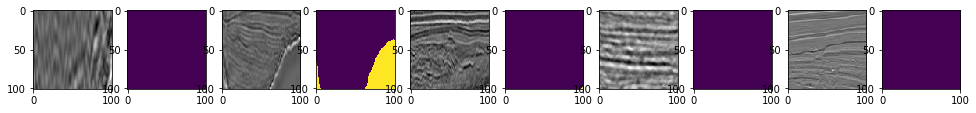

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread('SaltID/train/images/' + img_name + '.png')
    img_mask = imread('SaltID/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [8]:
depths = pd.read_csv("SaltID/depths.csv")
print(depths['z'].min(), depths['z'].max())

50 959


In [9]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        anti_aliasing=True,
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [10]:
# # Get and resize train images and masks
# X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
# print('Getting and resizing test images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
#     img = imread(path_test + '/images/' + id_)
#     x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
#     X_test[n] = x

# print('Done!')

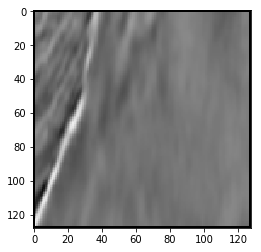

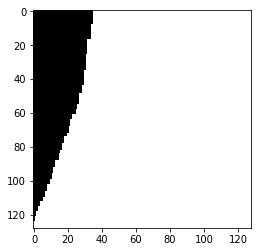

In [11]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [12]:
# # Check if training data looks all right
# ix = random.randint(0, len(test_ids))
# plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
# plt.show()

In [13]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [14]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [16]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

#X_test_shaped = X_test.astype(np.float32)

In [53]:
len(X_train_shaped)

4000

In [151]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped, train=True, preprocessed_masks=Y_train_shaped)
#salt_ID_dataset_test = saltIDDataset(X_test_shaped, train=False)

batch_size = 100
n_iters = 4000
num_epochs = n_iters / (len(X_train_shaped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
#                                           batch_size=batch_size, 
#                                           shuffle=False)

In [152]:
num_epochs

100

In [153]:
def conv_relu(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

def double_conv(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1 (?)
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, 8, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(8, 16, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(16, 32, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(32, 64, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(64, 128, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(128, 64, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(128, 64, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(64, 32, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(64, 32, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(32, 16, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(16, 8, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(16, 8, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(8, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        #print(conv1.size(), maxpool1.size())

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        #print(conv2.size(), maxpool2.size())

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        #print(conv3.size(), maxpool3.size())

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        #print(conv4.size(), maxpool4.size())
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        #print(conv5.size())
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        #print(t_conv4.size(), ex_conv4.size())
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        #print(t_conv3.size(), ex_conv3.size())

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        #print(t_conv2.size(), ex_conv2.size())
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        #print(t_conv1.size(), ex_conv1.size())
        
        one_by_one = self.one_by_one(ex_conv1)
        #print(one_by_one.size())
        #final = self.final_act(one_by_one)
        
        #final = torch.where((final > .5).cuda(), ones, zeros)
        
        return one_by_one

In [154]:
model = Unet()
model.cuda();

In [155]:
criterion = nn.BCEWithLogitsLoss()

In [156]:
learning_rate = 0.000001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [157]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

In [158]:
ones = torch.ones(batch_size, 1, 128, 128).cuda()
zeros = torch.zeros(batch_size, 1, 128, 128).cuda()

In [160]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(train_loader):        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 100 == 0:
            
            t_scores = []
            # Iterate through test dataset
            for threshold in [.5]: #, .55, .6, .65, .7, .75, .8, .85, .9, .95]:
                true_pos = 0
                false_pos = 0
                false_neg = 0
                #print(threshold)
                for images, masks in train_loader:

                    images = Variable(images.cuda())
                    masks = masks.cuda()

                    outputs = model(images)
                    
                    bin_outputs = torch.where(outputs > .5, 
                                              ones, 
                                              zeros).byte()
                    bin_masks = masks.byte()
                    
                    for bin_output, bin_mask in zip(bin_outputs, bin_masks):
                        #print(bin_output | bin_mask)
                        #print(bin_output & bin_mask)
                        union = (bin_output | bin_mask).sum()
                        inter = (bin_output & bin_mask).sum()
                        #print(union, inter)
                        if inter == 0:
                            iou = 0
                        else:
                            iou = inter / union
                        
                        #print("iou", iou)
                        
                        mask_obj = bin_mask.any()
                        output_obj = bin_output.any()
                        
                        if iou > threshold:
                            true_pos += 1
                        elif iou <= threshold and mask_obj:
                            false_neg += 1
                        elif iou <= threshold and output_obj:
                            false_pos += 1
                        elif not mask_obj and not output_obj:
                            true_pos += 1
                        else:
                            print("freak out")
                
                t_score = true_pos / (true_pos + false_pos + false_neg)
                    
                t_scores.append(t_score)

            # Print Loss
            print('Iteration: {}. Loss: {}. Mean IU: {}'.format(iter, loss.data.item(), np.mean(t_scores)))

Iteration: 100. Loss: 0.724475085735321. Mean IU: 0.295
Iteration: 200. Loss: 0.7178138494491577. Mean IU: 0.294
Iteration: 300. Loss: 0.7158489227294922. Mean IU: 0.29475
Iteration: 400. Loss: 0.7098028063774109. Mean IU: 0.296
Iteration: 500. Loss: 0.7068670392036438. Mean IU: 0.2965
Iteration: 600. Loss: 0.7054712772369385. Mean IU: 0.298
Iteration: 700. Loss: 0.7044743299484253. Mean IU: 0.3
Iteration: 800. Loss: 0.70143723487854. Mean IU: 0.302
Iteration: 900. Loss: 0.697557806968689. Mean IU: 0.30475
Iteration: 1000. Loss: 0.6925376653671265. Mean IU: 0.3045
Iteration: 1100. Loss: 0.6904569864273071. Mean IU: 0.306
Iteration: 1200. Loss: 0.6881270408630371. Mean IU: 0.30825
Iteration: 1300. Loss: 0.6834463477134705. Mean IU: 0.312
Iteration: 1400. Loss: 0.6844977736473083. Mean IU: 0.31525
Iteration: 1500. Loss: 0.6808454394340515. Mean IU: 0.31825
Iteration: 1600. Loss: 0.6800452470779419. Mean IU: 0.31975
Iteration: 1700. Loss: 0.6819299459457397. Mean IU: 0.32525
Iteration: 18

In [149]:
torch.cuda.empty_cache() 

In [284]:
#nope

In [45]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=False)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''

model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
            
        print(images[0].size())
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        print("outputs", outputs[0])
        print("outputs", outputs.size())
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

torch.Size([1, 28, 28])
outputs tensor([-0.0354,  0.0021,  0.0959,  0.0662,  0.1728,  0.0752, -0.0600,
         0.0476,  0.0564,  0.0037], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0369, -0.0064,  0.1112,  0.0533,  0.1395,  0.0700, -0.0920,
         0.1307,  0.0379,  0.0133], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.0767, -0.0077,  0.0508,  0.1065,  0.1026,  0.0628, -0.0717,
         0.2221,  0.0160,  0.0367], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0224,  0.0556,  0.0188,  0.0777,  0.2190,  0.1187, -0.1065,
         0.0858,  0.0145,  0.0339], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0363,  0.0099,  0.0975,  0.0424,  0.1476,  0.0685, -0.0631,
         0.1018,  0.0499, -0.0099], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0461, -0.0076,  0.0435,  0.

         0.0143,  0.0516,  0.0235], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1794, -0.0639,  0.0507,  0.0345,  0.0348, -0.0156,  0.0931,
         0.0110,  0.0361,  0.0540], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.3054, -0.1305,  0.0329,  0.2335, -0.0375, -0.0407,  0.0650,
         0.1272,  0.1139,  0.0428], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0706,  0.1913,  0.0251,  0.0315,  0.0780, -0.0119,  0.0121,
        -0.0067,  0.0431,  0.0853], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1166, -0.0343,  0.2145,  0.1405,  0.0006, -0.0958,  0.0862,
        -0.0074, -0.0192, -0.0109], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1138, -0.0154,  0.1291,  0.0662,  0.1381, -0.0424,  0.1362,
         0.1300,  0.0791,  0.1535], device='cuda:0')
outputs torch.Siz

        -0.0012,  0.0926,  0.0465], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2153, -0.0504,  0.2772,  0.2818, -0.1421,  0.0669,  0.0317,
        -0.0242,  0.1201, -0.0375], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.1481, -0.0290, -0.1409,  0.1086,  0.3453, -0.0198,  0.0365,
         0.2119,  0.1191,  0.3218], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2340, -0.0736,  0.3007, -0.0311,  0.1794, -0.0829,  0.2216,
        -0.1064, -0.0870, -0.0133], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2652, -0.1691,  0.3380,  0.0815,  0.0676, -0.0719,  0.2719,
        -0.0319, -0.0028, -0.0902], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1938, -0.2902,  0.1751,  0.0342,  0.3414, -0.0626,  0.3366,
         0.1982,  0.0506,  0.1300], device='cuda:0')
outputs torch.Siz

         0.7299, -0.5839, -0.0612], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1095, -3.2071, -0.1937,  0.4844,  2.8280,  0.3546,  0.6588,
         1.0491,  0.0116,  2.2217], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-2.4633,  2.5973,  0.9664,  0.6828, -0.7169, -0.5276, -0.2374,
        -0.5142,  1.7331,  0.2319], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.2908, -3.0596, -0.1102, -0.3009,  3.1181,  0.2988,  0.7352,
         1.2592, -0.4123,  1.7364], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 3.9002, -3.3961,  0.2875, -0.4300, -0.4254,  1.2915,  1.3027,
        -0.3025, -0.1085, -0.4615], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 1.1425, -1.2507,  0.6056,  0.1768, -0.0134,  0.8096,  0.7994,
        -0.7930,  0.2489, -0.2901], device='cuda:0')
outputs torch.Siz

         2.0259,  0.7414,  3.2745], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 6.0450, -5.1816,  0.9030, -0.2671, -1.7518,  3.4095,  1.5848,
        -1.8137,  1.1323, -1.6111], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 8.5523, -8.6859,  1.2617,  0.4020, -2.3608,  4.2083,  1.4746,
         0.0452,  0.1328, -0.9304], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-3.2874, -1.5156, -1.7492,  1.5842,  0.8070,  0.4526, -2.3235,
         5.2667,  1.2368,  3.5535], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.1465, -3.0072,  1.7798,  0.3348,  1.8169,  0.1279, -1.1191,
         2.8497,  0.5199,  2.4901], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-1.4875, -3.1280, -0.7397,  2.7330,  0.0189,  1.2328, -2.8664,
         5.9061, -0.0935,  3.1961], device='cuda:0')
outputs torch.Siz

KeyboardInterrupt: 

In [41]:
torch.ones(1, 128, 128)

tensor([[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]])

In [43]:
torch.zeros(1, 128, 128)

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [152]:
dir(train_dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 'download',
 'processed_folder',
 'raw_folder',
 'root',
 'target_transform',
 'test_file',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'urls']

In [157]:
train_dataset.train_labels[9]

tensor(4)